# Introduction to Latent space representations, Autoencoders and Variational Autoencoders

In this tutorial we will use Autoencoders (AE) and Variational Autoencoders (VAE) on sea surface temperature (SST) anomalies in the tropical Pacific.

In parts, this tutorial is based on [Jakob Schlör's tutorial](https://github.com/mlcs/seminar_ws22/blob/main/04_vae/tutorial_vae_ssta.ipynb), developed for the Machine Learning in Climate Science lecture WS 21/22. 

# 0. Before you start

Please download the following dataset from this [nextcloud-link](https://nc.mlcloud.uni-tuebingen.de/index.php/s/W8QeBkXm2i5xGpw) to your local machine or directly into your notebook via:

`! wget https://nc.mlcloud.uni-tuebingen.de/index.php/s/W8QeBkXm2i5xGpw -O piControl_monthly.zarr`

For plotting please download and install the [geoutils](https://github.com/fstrnad/geoutils) package via `pip install -e .` .

Ensure that you have installed the following necessary imports. 
These can be installed, for example via:

`mamba create -n ml ipykernel xarray zarr cftime scikit-learn scipy pytorch pytorch-cuda=12.4 matplotlib cartopy -c pytorch -c nvidia -c conda-forge`

If plotting maps takes longer than a few seconds, it might be beneficial to install cartopy(version 0.24.1) directly via
`pip install cartopy`


In [1]:
import cartopy
from importlib import reload
import geoutils.utils.spatial_utils as sput
import geoutils.plotting.plots as gplt
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(f'Cartopy version: {cartopy.__version__}')

GPU: Quadro T2000 is available.
cuda
Cartopy version: 0.24.1


## 1. Familiarize yourself with the data

Many atmospheric phenomena are driven by the oceans, since they contain most of the heat. Sea surface temperatures (SST) fields can help us predict and understand many atmospheric processes. Anomalies in the Pacific SST can lead to large climatic changes world wide.


The monthly SST data of model runs for 2000 years are taken from the [CESM2](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)-model. 
The data are available on a $1^\circ \times 1^\circ$ resolution.




**Question**: What are anomalies in climate science and how are SST anomalies calculated?

**Answer**: 
In climate science, anomalies are used to highlight changes in climate variables (such as temperature, precipitation, or atmospheric pressure) by comparing current observations to a baseline or reference period. Anomalies help to remove seasonal variations and year-to-year fluctuations, allowing scientists to focus on long-term trends or unusual events.
First the data is detrended. The anomalies are estimated as follows: 
- The mean value of the climate variable (e.g., temperature or precipitation) is calculated for each time unit (e.g., month, season, or year) over the reference period.
- The mean value of the climate variable (e.g., temperature or precipitation) is calculated for each time unit (e.g., month, season, or year) over the reference period.
- The anomaly is calculated by subtracting the average value from the observed value for the specific time period. Mathematically:
  
  `Anomaly = Observed Value - Reference Period Mean`
  
Anomalies help to identify whether specific conditions (such as a particularly warm or cold year) are unusual or part of natural variability. They are especially useful in long-term studies, such as detecting climate change, because they allow scientists to compare observed changes to historical averages.
  



We use the python package xarray to read the observation variables. The SST-Anomalies are already available in the file. The variable is called `ssta`

e use the python package xarray to read the observation variables. The SST-Anomalies are already available in the file. The variable is called `ssta`

In [2]:
filepath = '/home/strnad/data/CMIP6_LENS/CESM2/piControl_monthly.zarr'
da = xr.open_zarr(filepath)['ssta']
da

<xarray.DataArray 'ssta' (time: 24000, lat: 64, lon: 160)> Size: 983MB
[245760000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 512B -31.0 -30.0 -29.0 -28.0 ... 29.0 30.0 31.0 32.0
  * lon      (lon) float64 1kB 130.0 131.0 132.0 133.0 ... 287.0 288.0 289.0
    month    (time) int64 192kB ...
  * time     (time) object 192kB 0001-02-01 00:00:00 ... 2001-01-01 00:00:00

We can easily plot the SST anomaly maps for some time points.
You can find the specific plotting function in the geoutils package.


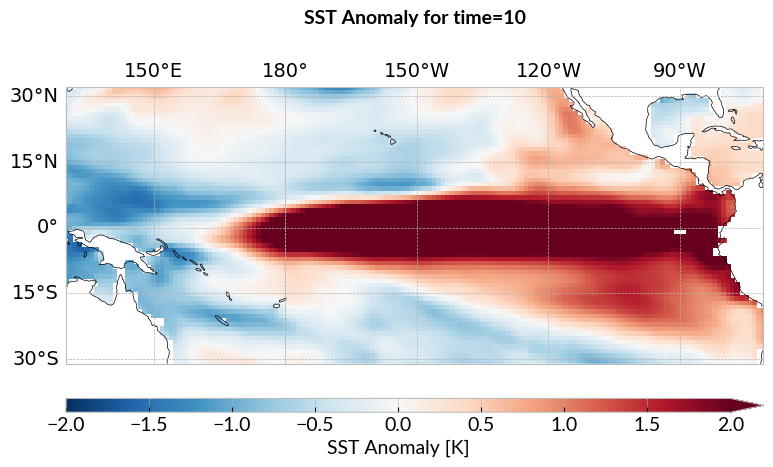

In [3]:
reload(gplt)
reload(sput)
timepoint = 10
data_map = da.isel(time=timepoint)
im = gplt.plot_map(data_map,
                   title=f'SST Anomaly for time={timepoint}',
                   cmap='RdBu_r',
                   vmin=-2, vmax=2,
                   label='SST Anomaly [K]',
                   dateline=True,)

Each grid point on the map encodes a time-series.
We can select coordinates using the `.sel()` method (see [xarray tutorial](https://xarray.pydata.org/en/stable/user-guide/indexing.html) for details)


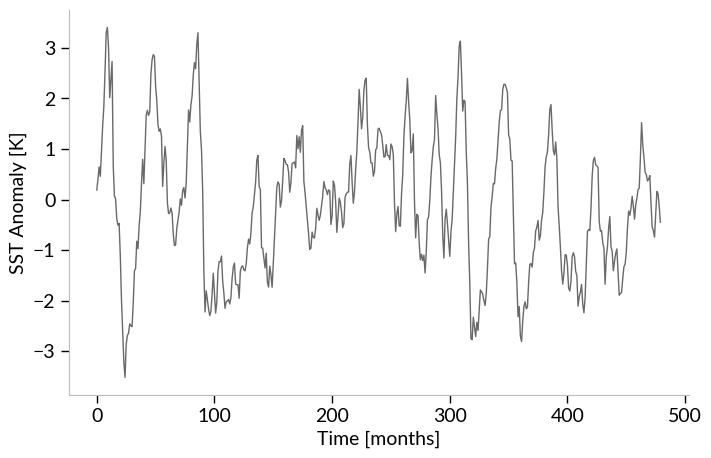

In [4]:
# Select single point, and plot the corresponding time series
reload(gplt)
num_years = 40
ts_sample = da.sel(lat=0, lon=180, method='nearest')[0:num_years*12]
im = gplt.plot_2d(y=ts_sample.data,
                  x=np.arange(len(ts_sample)),
                  xlabel='Time [months]',
                  ylabel='SST Anomaly [K]')

### El Nino Southern Oscillation (ENSO)

The largest interanual variability of the climate is characterized by SST anomalies in the tropical Pacific, called the **El Nino Southern Oscillation (ENSO)**. ENSO has a neutral phase and oscillates between a warm phase called **El Nino** and a cold phase called **La Nina**.
This oscillation has a strong impact on the global climate.

The phases of ENSO can be described using the average time series over the Nino3.4 region.
The El Nino phase (warm) is defined as Nino3.4 > 0.5 and the La Nina (cold) phase as Nino3.4<-0.5.

![Nino](images/nino_regions.png) [Ref.](https://climatedataguide.ucar.edu/sites/default/files/users/dschneid/key_figures_428.png)

Using the xarray package it is easy to compute the average over the Nino3.4 box:


In [5]:
def get_nino34(da):
    nino34_region = da.sel(lat=slice(-5, 5), lon=[170, 240])
    nino34 = nino34_region.mean(dim=('lon', 'lat'), skipna=True)
    nino34 = nino34.rename('nino34')
    return nino34
nino34 = get_nino34(da)
nino34

<xarray.DataArray 'nino34' (time: 24000)> Size: 96kB
array([ 0.21285476,  0.26398394,  0.60555154, ..., -0.9900854 ,
       -0.98742795, -1.0612721 ], shape=(24000,), dtype=float32)
Coordinates:
    month    (time) int64 192kB ...
  * time     (time) object 192kB 0001-02-01 00:00:00 ... 2001-01-01 00:00:00

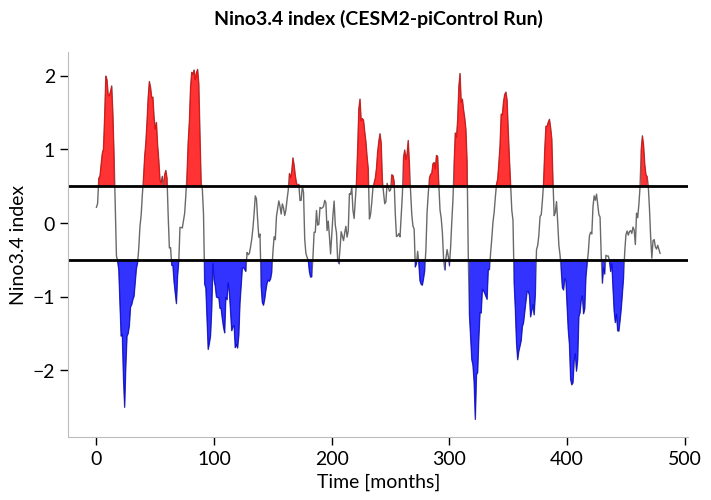

In [6]:
# Plot Nino3.4 index for the first 40 years
reload(gplt)
plot_nino34 = nino34[0:num_years*12]
time = np.arange(len(plot_nino34['time']))
data = plot_nino34.values
im = gplt.plot_2d(x=time, y=data,
                  title='Nino3.4 index (CESM2-piControl Run)',
                  xlabel='Time [months]', ylabel='Nino3.4 index')
ax = im['ax']
gplt.fill_between(ax=ax, x=time, y=data, y2=0.5,
                  color='r', alpha=0.8)
gplt.fill_between(ax=ax, x=time, y=data, y2=-0.5, larger=False,
                  color='b', alpha=0.8)
ax.axhline(-0.5, color='k')
ax.axhline(0.5, color='k')

# 2. Latent space representation through dimensionality reduction

We want to find descriptive representations. In Geoscience the most popular method is Principal Component Analysis.
 
It finds the main directions (principal components) in which the data varies the most. By projecting the data onto these directions, PCA helps to keep the most important information while discarding less important details. This makes it easier to analyze and visualize large datasets, especially when there are many variables, by focusing on the key patterns. 

Essentially, it’s like rotating and scaling the data so the most significant features stand out clearly.

We first introduce a dataclass to better preprocess the input data

In [7]:
class SSTA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA.
    """

    def __init__(self, dataarray):
        self.dataarray = dataarray
        self.time = self.dataarray['time'].data
        self.lat = self.dataarray['lat'].data
        self.lon = self.dataarray['lon'].data

        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0, :])
        self.X = X[:, ~self.idx_nan]

    def __len__(self):
        """Returns the number of datapoints."""
        return self.X.shape[0]

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = torch.from_numpy(self.X[idx]).float()
        label = {'idx': idx}

        return x, label

    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.nan
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map

We create an instance of the dataset. 

**Question:** Why is it important to make some preprocessing?

In [9]:
dataset = SSTA(da)
# Sample datapoint
X = dataset.X
x_dim = X.shape
print(f"Shape of original input: {da.shape}")
print(f"Shape of non-nan input: {x_dim}")


Shape of original input: (24000, 64, 160)
Shape of non-nan input: (24000, 9122)


**Answer:** 
As SST only covers the oceans, values over land are encoded as np.nan values. We need to ignore those and remove them from the dataset before preceeding.

Now we apply a principal component analysis (PCA). A principal component analysis can be regarded as some form of an encoder - decoder process. 
The reduced dimensionality space encodes is in the ML often called the *latent space*.

<img src="images/method_sketch_enso.png" width="1300"> 


In [10]:
X = X.reshape(da.shape[0], -1)
num_pcs = 10
pca = PCA(n_components=num_pcs)
# This projects the input to the latent space of dimension num_components
z = pca.fit_transform(X)

**Question:** How many PCs are needed to describe the data meaningfully?

**Answer:** There is no universal to it. But you can get an idea when plotting the ratio of explained variance per PC

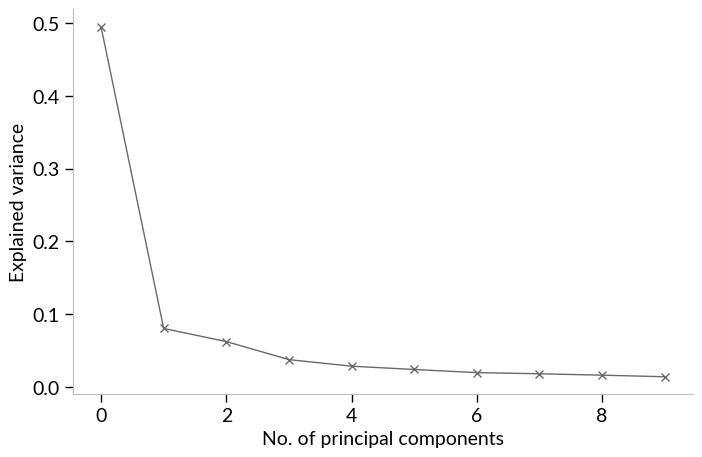

In [11]:
reload(gplt)
explained_variance = pca.explained_variance_ratio_
im = gplt.plot_2d(y_arr=explained_variance,
                  xlabel='No. of principal components',
                  ylabel='Explained variance',
                  mk='x'
                  )

For our purposes, two PCs should be enough. 
We can plot the first principal components.

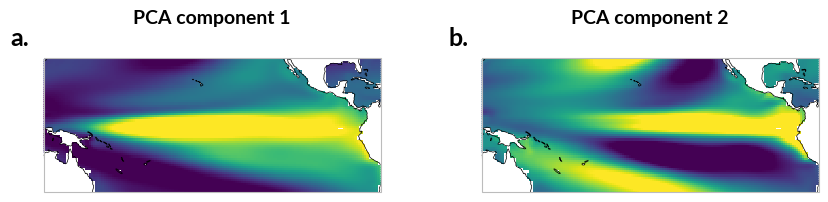

In [13]:
num_pcs = 2
pca = PCA(n_components=num_pcs)
# This projects the input to the latent space of dimension num_components
z = pca.fit_transform(X)
im = gplt.create_multi_plot(nrows=1, ncols=num_pcs, projection='PlateCarree',
                       central_longitude=180, wspace=0.3)

for i in range(num_pcs):
    da_map = dataset.get_map(pca.components_[i])
    gplt.plot_map(da_map, title=f'PCA component {i+1}', ax=im['ax'][i],
                       cmap='viridis')

Now visualize the latent space of the first two principal components.

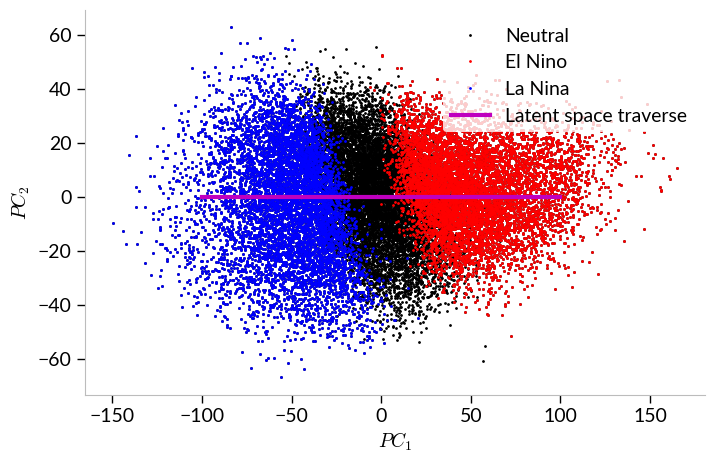

In [14]:
reload(gplt)
nino34_data = get_nino34(dataset.dataarray)

# get all encodings for El Nino conditions
nino_idx = np.where(nino34_data > 0.5)[0]
# get all encodings for La Nina conditions
nina_idx = np.where(nino34_data < -0.5)[0]

# Create traverse through latent space
z_samples = np.linspace((-100, 0), (100, 0), 5)

im = gplt.plot_2d(x_arr=[z[:,0], z[nino_idx,0], z[nina_idx,0], z_samples[:,0]],
             y_arr=[z[:,1], z[nino_idx,1], z[nina_idx,1], z_samples[:,1]],
             label_arr=['Neutral', 'El Nino', 'La Nina', 'Latent space traverse'],
             color_arr=['k', 'r', 'b', 'm'],
             mk_arr=['o', 'o', 'o', 'x'],
             marker_size=1,
             ls_arr=['', '', '', '-'],
             lw=3,
             xlabel=r"$PC_1$",
             ylabel=r"$PC_2$"
             )



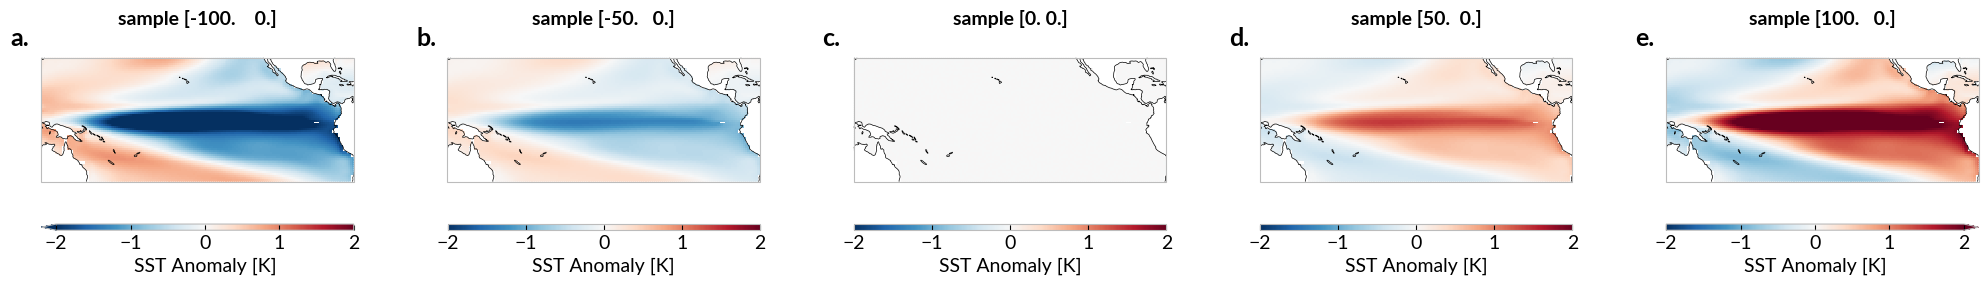

In [15]:
# Plot reconstructions
im = gplt.create_multi_plot(nrows=1, ncols=len(z_samples), projection='PlateCarree',
                            dateline=True, wspace=0.3)
axs = im['ax']

for idx, sample in enumerate(z_samples):
    # Create sample datapoint
    x_sample = pca.inverse_transform(sample.T)
    da_sample = dataset.get_map(x_sample)
    im = gplt.plot_map(da_sample,
                       ax=axs[idx],
                       title=f'sample {sample}',
                       cmap='RdBu_r', label='SST Anomaly [K]',
                       vmin=-2, vmax=2)

# 3. Autoencoding with deep learning architectures

Now we prepare the learning pipeline for using neural networks as non-linear encoders and decoders.


Pytorch use their own datatype, pytorch.Tensors which is very similar to numpy. In order to use our SST anomaly data as inputs to neural networks (NN) we have to preprocess the data. The following preprocessing steps are usually required:

1. **Adapt input size**: Since we will use linear NN, we have to flatten the maps into vectors.

2. **Normalization**: Data should be normalized, e.g. between 0 and 1. For anomaly data this is not necessarily required since the data is already bounded and equally distributed around 0.

It is convenient to define a Dataset class with which we can use the Dataloader objects predefined by pytorch.


**Question:** What is the input dimension of the NN input?

**Answer:** Use the same input as for the PCA and print the shape.

In [16]:
dataset = SSTA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of original input: {da[0].shape}")
print(f"Shape of NN input: {x_dim}")


Shape of original input: (64, 160)
Shape of NN input: 9122


We split the data randomly in a training and validation dataset (80% to 20%).

We process these datapoints in parallel using pytorch `Dataloader`. 
The Dataloader allows to process a set of datapoints, i.e. minibatch at the same time. The size of the minibatch depends on the number of datapoints we have.



In [17]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(
    dataset, [n_training, len(dataset) - n_training])

# Define data loader
batch_size = 50
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## 3.1 Autoencoder

Now we can start defining our autoencoder (AE). AE are used to reconstruct high-dimensional data using NN with a narrow bottleneck layer. It is often used for dimensionality reduction, like Principal Component Analysis. AE are optimized to obtain good reconstructions.

The Autoencoder consists of:

- The encoder network $g_\phi(x)$ translates the input $x$ to the low-dimensional latent code $z$.
- The decoder network $f_\theta(z)$ recovers the data from the latent code.

<img src="images/autoencoder_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)

We find the parameters $\theta$ and $\phi$ to minimize the reconstruction error:

$L_{\mathrm{AE}}(\theta, \phi)=\frac{1}{n} \sum_{i=1}^{n}\left(\mathbf{x}^{(i)}-f_{\theta}\left(g_{\phi}\left(\mathbf{x}^{(i)}\right)\right)\right)^{2}$

Thus, both Encoder and Decoder are trained together.

In this case we build a very simple Autoencoder with:

- Encoder: $x$ -> Linear(256) -> Linear(2) -> $z$
- Decoder: $z$ -> Linear(256) -> Linear(dim_x) -> $x'$


In [18]:
class AE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space.
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim, num_neurons=256):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        self. encoder = nn.Sequential(
            nn.Linear(x_dim, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, x_dim),
        ).to(self.device)

    def forward(self, x):
        """Pass through encoder and decoder.

        Args:
            x (tensor): (batch, x_dim) Input to AE.

        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z

    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """

        # Encode and decoder input
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='mean')

        return rec_loss_pointwise

Initialize the AE:


In [19]:
num_neurons = 256
ae = AE(x_dim=x_dim, z_dim=2, num_neurons=num_neurons)

print('Encoder:', ae.encoder)
print('Decoder:', ae.decoder)
print('device:', ae.device)

Encoder: Sequential(
  (0): Linear(in_features=9122, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)
Decoder: Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=9122, bias=True)
)
device: cuda


**Question:** How many parameters does our model have?

**Answer:** Go through all layers of the encoder and decoder network and sum up:

In [20]:
if True:
    print('Number of encoder weights:', (num_neurons*x_dim + num_neurons + num_neurons*2 + 2))
    print('Number of decoder weights:', (num_neurons*2 + num_neurons + num_neurons*x_dim + x_dim))

    print("Number of trainable parameters of our model:",
          sum(p.numel() for p in ae.parameters() if p.requires_grad))

Number of encoder weights: 2336002
Number of decoder weights: 2345122
Number of trainable parameters of our model: 4681124


## 3.2 Training an NN

We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data. No gradients are computed for the validation data.


In [21]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

In [22]:
# The training loop
training = False

epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)

if training:
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        val_epoch_loss = validate_epoch(
            ae, val_loader
        )
        train_epoch_loss = train_epoch(
            ae, train_loader, optimizer
        )
        if epoch % 10 == 0:
            print(f"Epoch {epoch} of {epochs}")
            print(f"Train Loss: {train_epoch_loss:.4f}")
            print(f"Val Loss: {val_epoch_loss:.4f}")
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)

# save the weights
savepath = './weights/ae_weights.pth'
if training:
    torch.save(ae.state_dict(), savepath)
else:
    ae.load_state_dict(torch.load(savepath))

/tmp/ipykernel_10239/2517496404.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(savepath))


The first evaluation of the training is by plotting the loss on the training data and on the validation data for each epoch:


In [ ]:
reload(gplt)
im = gplt.plot_2d(y_arr=[train_loss, val_loss],
                  label_arr=['training', 'validation'],
                  xlabel='epochs', ylabel='MSE',
                #   ylim=[0.1, 0.2],
                  ylog=True)

We compare the input and reconstructed images qualitatively:


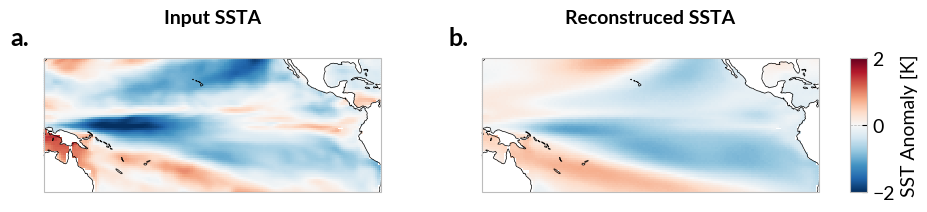

In [23]:
reload(gplt)
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, z = ae.forward(x.to(ae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec)

# Plotting
im = gplt.create_multi_plot(nrows=1, ncols=2, projection='PlateCarree',
                            dateline=True, wspace=0.3)
gplt.plot_map(da_in, ax=im['ax'][0], vmin=-2, vmax=2,
              title=f"Input SSTA", cmap='RdBu_r',
              )
_ = gplt.plot_map(da_rec, ax=im['ax'][1], vmin=-2, vmax=2,
                  title="Reconstruced SSTA", cmap='RdBu_r',
                  label='SST Anomaly [K]', orientation='vertical')

## 3.3 The latent space of a NN Autoencoder

The latent space is a low dimensional representation of the input. In the following we will analyze the structure of the latent space.
We can encode the input datapoints to the latent space to visualize its representation in the latent space.


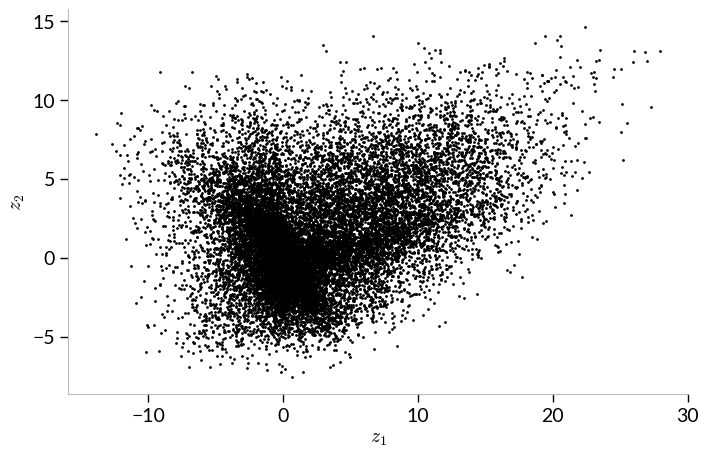

In [24]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, l = x
            # Encode data
            z = model.encoder(x.to(model.device))

            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
                encode['idx'] = l['idx']
            else:
                encode['z'] = np.vstack(
                    [encode['z'], z.cpu().detach().numpy()])
                encode['idx'] = np.concatenate((encode['idx'], l['idx']))
    return encode


encode = encoding(ae, train_loader)

# Plot the encoding
im = gplt.plot_2d(x=encode['z'][:, 0],
             y=encode['z'][:, 1],
             ls='', mk='o', color='k',
             marker_size=1,
             xlabel=r"$z_1$", ylabel=r"$z_2$",)

The latent space is a low dimensional representation of the data. 

We can explore whether this representation has some physical meaning.

Therefore, we check how El Ninos and La Ninas are distributed in this space:


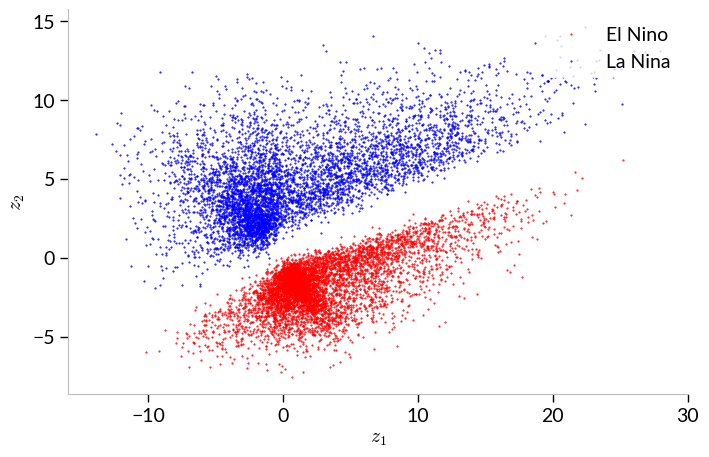

In [25]:
reload(gplt)
nino34_train = get_nino34(train_data.dataset.dataarray)

# get all encodings for El Nino conditions
nino_idx = np.flatnonzero(
    np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
# get all encodings for La Nina conditions
nina_idx = np.flatnonzero(
    np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


im = gplt.plot_2d(x_arr=[encode['z'][nino_idx, 0], encode['z'][nina_idx, 0]],
             y_arr=[encode['z'][nino_idx, 1], encode['z'][nina_idx, 1]],
             label_arr=['El Nino', 'La Nina'],
             color_arr=['r', 'b'],
             ls='', mk='o',
             xlabel=r"$z_1$", marker_size=0.5, ylabel=r"$z_2$",)

### Traversing the latent space

Another method for studying the latent space is by travsing (walking) through the low dimensional space and decoding each step.


tensor([[  0., -10.],
        [  0.,  -5.],
        [  0.,   0.],
        [  0.,   5.],
        [  0.,  10.]])


{'ax': <Axes: xlabel='$z_1$', ylabel='$z_2$'>,
 'im': [<matplotlib.lines.Line2D at 0x73a082379df0>],
 'fig': <Figure size 800x500 with 1 Axes>}

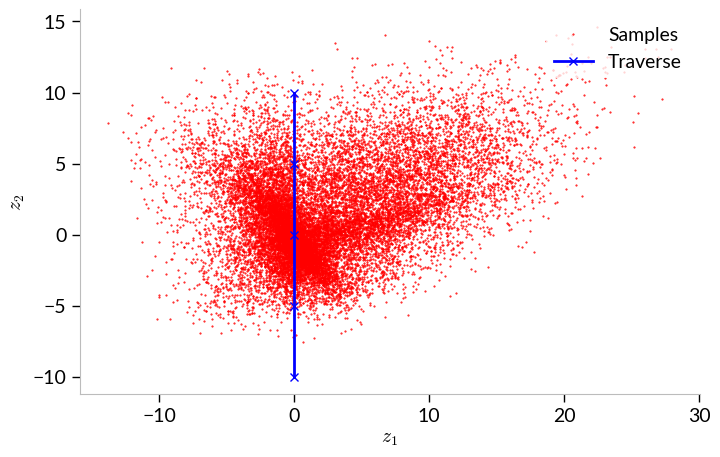

In [26]:
reload(gplt)
z_start = torch.Tensor([[-0, -0]])
z_eps = torch.Tensor([0, 1])
z_range = torch.linspace(-10, 10, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1) + z_range.unsqueeze(1) * z_eps
print(z_samples)

# Plot latent space
gplt.plot_2d(x_arr=[encode['z'][:, 0], z_samples[:, 0]],
             y_arr=[encode['z'][:, 1], z_samples[:, 1]],
             label_arr=['Samples', 'Traverse'],
             color_arr=['r', 'b'],
             ls_arr=['', '-'],
             mk_arr=['o', 'x'],
             mk_size_arr=[0.5, 6],
             lw_arr=[0.5, 2],
             xlabel=r"$z_1$", ylabel=r"$z_2$",)



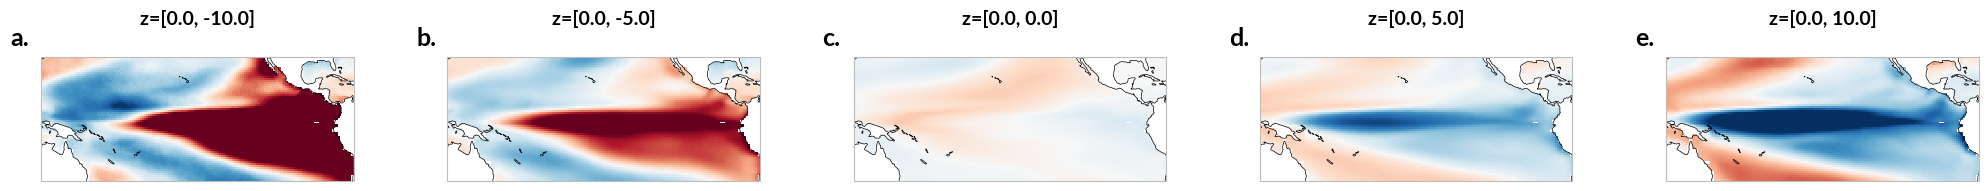

In [27]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))

# Plot reconstructions
im = gplt.create_multi_plot(nrows=1, ncols=len(z_range), projection='PlateCarree',
                            central_longitude=180, wspace=0.3)
axs = im['ax']
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    gplt.plot_map(da_rec, ax=axs[i], vmin=-2, vmax=2, cmap='RdBu_r',
                  title=f"z={z_samples[i].tolist()}")

# 4. Variational Autoencoder

**Question:** Variational Autoencoders are conceptually similar to a classical Autoencoders. What is their main difference?

**Answer:** Their mathematical formulation is different as we infer probability distributions over input $x$ and latent variables $z$. Instead of mapping the input $x$ to a fixed vector, we map it into a conditional distribution which is parametrized by the encoder network.

The aim is to approximate the distribution of the data:

$x \sim p(x) = \int dz p(x|z) p(z)$

using Bayes' rule our problem formulation is

$p_{\theta}(z|x) = \frac{p_\phi(x|z) p(z)}{\int_z dz p_\phi(x|z) p(z)}$

where:

- $p(z)$ is the prior
- $p_\phi(x|z)$ is the likelihood parametrized by the decoder network
- $p_\theta(z|x)$ is the posterior distribution parametrized by the encoder network. It is often approximated as $q(z|x)$

<img src="images/vae_simple.png" width="900"> [Ref.](https://www.jeremyjordan.me/variational-autoencoders/)


We can formulate this problem as an optimization using variational inference. Our objective is the *evidence lower bound (ELBO)* which needs to be maximized, i.e.

$\theta^*, \phi^* = \argmin_{\theta, \phi} L_{\text{VAE}}(\theta, \phi) = \argmin_{\theta, \phi} \left[ -\mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z} \mid \mathbf{x})} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})+D_{\mathrm{KL}}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z})\right) \right]$.

The first term is called the _reconstruction loss_ and the second term is often denoted as a _regularization_.


### Kullback-Leibler divergence

**Question:** How can ELBO method be implemented?

**Answer:** In the ELBO above, we use the Kullback-Leibler (KL) divergence to write our inference problem. The KL-divergence quantifies the distance between tow distributions $Q$ and $P$ and is defined as,

$ D*{\mathrm{KL}}(Q \mid P)=\mathbb{E}*{z \sim Q(z)} \log \frac{Q(z)}{P(z)} $

Note that the KL-divergence is not symmetric, i.e. $D_{\mathrm{KL}}(Q \mid P) \neq D_{\mathrm{KL}}(P \mid Q)$.

In the case above the KL-divergence basically measures the distance between the prior $p(z)$ and the approximate likelihood $q_{\phi}(\mathbf{z} \mid \mathbf{x}) \approx p_\theta(z|x)$.

For two Gaussians $q(z) = \mathcal{N}_1(\mu_1, \sigma_1^2, 1)$ and $p(z) = \mathcal{N}_2(\mu_2, \sigma_2^2, 1)$ the KL-divergence can be computed analytically as,

$D_{KL}(q|p) = 0.5 * \left[ log(\sigma_2) - log(\sigma_1) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{\sigma_2^2 } -1 \right]$


In [97]:
def kl_normal(q_m, q_logv, p_m, p_logv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension.

    kl(q|p) = 0.5 * (log(p_v) - log(q_v) + (q_v**2 + (q_m - p_m)**2)/ p_v**2 - 1)

    Args:
        q_m (tensor): (batch, dim): q mean
        q_logv (tensor): (batch, dim): q log variance
        p_m (tensor): (batch, dim): p mean
        p_logv (tensor): (batch, dim): p log variance

    Return:
        kl (tensor):(batch,): kl between each sample
    """
    element_wise = 0.5 * (2*p_logv - 2*q_logv + q_logv.exp() / p_logv.exp()
                          + (q_m - p_m).pow(2) / p_logv.exp() - 1)
    kl = element_wise.sum(-1)
    return kl

### Reparametrization Trick

**Question:** What is the problem with the Loss term?

**Answer:** The expectation term in the loss functions requires generating samples from $z \sim q_\phi(z|x)$. 
However, we cannot backpropagate gradients through stochastic processes. 

In order to make the VAE still trainable we use the so called reparametrization trick. The reparametrization trick is basically a transformation of $z$ to an auxiliary independent random variable $\epsilon$ parametrized by $\phi$.

For multivariate Gaussians with diagonal covariance structure this transformation is easy,

$\mathbf{z} \sim q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)=\mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)} \boldsymbol{I}\right)$

$\mathbf{z}=\boldsymbol{\mu}+\boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \text { where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I})\ $

It is therefore also called *stochastic backpropagation*.

<img src="images/reparameterization.png" width="900"> [Ref.](https://www.jeremyjordan.me/variational-autoencoders/)


In [98]:
def reparametrize(mu, log_v):
    """Sampling from a gaussian using the reparametrization trick.

    z = mu + v**2 * eps | eps ~ N(0,1)

    Args:
        mu (torch.Tensor): (batch, ...) mean from the encoder's latent space
        log_v (torch.Tensor): (batch, ...) log variance from the encoder's latent space

    Return:
        sample (tensor): (batch, ...)
    """
    std = torch.exp(0.5*log_v)  # standard deviation
    eps = torch.randn_like(std)
    sample = mu + (eps * std)  # sampling as if coming from the input space

    return sample

## 4.2 Implementation of the VAE class

We implement the VAE class similar to the AE class before.

For simplisity we use the following simplifications which are often assumed for VAE:

1. We assume a standard normal prior $p(z) = \mathcal{N}(z; 0,1)$
2. The likelihood is gaussian distributed $p_\phi(x|z) = \mathcal{N}(x; \mu_\phi(z), 1)$ parametrized by the decoder network.
   Thereby, $\log(p_\phi(x|z)) \propto MSE(x - x')$.
3. The posterior is also assumed to be Gaussian $q_\theta(z|x) = \mathcal{N}(z; \mu_\theta(x), \sigma_\theta^2(x) 1)$

<img src="images/vae_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)


In [109]:
class VAE(nn.Module):
    """Variational Auto encoder.

    Args:
        z_dim (int): Dimension of latent space.
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim, num_neurons=256):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        self. encoder = nn.Sequential(
            nn.Linear(x_dim, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, 2 * z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, x_dim),
        ).to(self.device)

    def forward(self, x):
        """Pass through encoder and decoder.

        Args:
            x (tensor): (batch, x_dim) Input to AE.

        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            q_m (tensor): (batch, z_dim) Mean of posterior q(z|x).
            q_logv (tensor): (batch, z_dim) Log variance of posterior q(z|x).
        """
        enc = self.encoder(x).view(-1, 2, self.z_dim)
        q_m = enc[:, 0, :]
        q_logv = enc[:, 1, :]
        z_given_x = reparametrize(q_m, q_logv)
        x_hat = self.decoder(z_given_x)

        return x_hat, q_m, q_logv

    def loss(self, x):
        """Loss function of VAE is the negative log likelihood.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """

        # Encode and decoder input
        x_hat, q_m, q_logv = self.forward(x)

        # Reconstruction loss, log(p(x|z))
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        rec_loss = torch.sum(
            torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)

        # KL divergence kl(q(z|x)|| p(z))
        p_m = torch.zeros_like(q_m)
        p_logv = torch.log(torch.ones_like(q_logv))
        kl = kl_normal(q_m, q_logv, p_m, p_logv)

        loss = rec_loss + kl

        return loss.mean()

Initialize out VAE model:


In [ ]:
vae = VAE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in vae.parameters() if p.requires_grad))
print('use device:', vae.device)

### Training

Train VAE with the same training functions as the AE before.
You can also skip this step and load the already trained weights.

In [ ]:
# Training parameters
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
training = True
train_loss = []
val_loss = []
if training:
    for epoch in range(epochs):
        val_epoch_loss = validate_epoch(
            vae, val_loader
        )
        train_epoch_loss = train_epoch(
            vae, train_loader, optimizer
        )
        if epoch % 10 == 0:
            print(f"Epoch {epoch} of {epochs}")
            print(f"Train Loss: {train_epoch_loss:.4f}")
            print(f"Val Loss: {val_epoch_loss:.4f}")
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)

# save the weights
savepath = './weights/vae_weights.pth'
if training:
    torch.save(vae.state_dict(), savepath)
else:
    vae.load_state_dict(torch.load(savepath))

Plot again the training and validation loss over the epochs.


In [ ]:
reload(gplt)
im = gplt.plot_2d(y_arr=[train_loss, val_loss],
                  label_arr=['training', 'validation'],
                  xlabel='epochs', ylabel='MSE',
                  ylim=[1600, 2000]
                  )

The reconstruction works the same, where we look at one decoded sample:


In [ ]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, q_m, q_logv = vae.forward(x.to(vae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec[0])

# Plotting
# Plotting
im = gplt.create_multi_plot(nrows=1, ncols=2, projection='PlateCarree',
                            dateline=True, wspace=0.3)
gplt.plot_map(da_in, ax=im['ax'][0], vmin=-2, vmax=2,
              title=f"Input SSTA", cmap='RdBu_r',
              )
_ = gplt.plot_map(da_rec, ax=im['ax'][1], vmin=-2, vmax=2,
                  title="Reconstruced SSTA", cmap='RdBu_r',
                  label='SST Anomaly [K]', orientation='vertical')

## 4.2 The Latent space of a VAE 

Very similar to the AE we can plot the latent space of the VAE. Keep in mind, that we are only plotting the mean of the posterior distribution $p(z|x)$.


In [ ]:
encode = encoding(vae, train_loader)

# get all encodings for El Nino and La Nina conditions
nino34_train = get_nino34(train_data.dataset.dataarray)
nino_idx = np.flatnonzero(
    np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
nina_idx = np.flatnonzero(
    np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


# Prior
# ut.plot_2dgaussian(np.zeros(2), np.diag(np.ones(2)), p=0.5,
#                    ax=ax, alpha=0.5, label=f'$p(z)$')
# Mean of p(z|x)
im = gplt.plot_2d(x_arr=[encode['z'][nino_idx, 0], encode['z'][nina_idx, 0]],
             y_arr=[encode['z'][nino_idx, 1], encode['z'][nina_idx, 1]],
             label_arr=['El Nino', 'La Nina'],
             color_arr=['r', 'b'],
             ls='', mk='o', xlabel=r"$z_1$", marker_size=0.5, ylabel=r"$z_2$",)

### Latent space traverse

The Gaussian assumption on the prior enforces that points which are similar in $x$ need to be close in $z$. That allows smooth transitions from one point to the other in latent space.


In [ ]:
reload(gplt)
z_start = torch.Tensor([[-0, -0]])
z_eps = torch.Tensor([1, -.5])
z_range = torch.linspace(-5, 5, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1) + z_range.unsqueeze(1) * z_eps

# Plot latent space
gplt.plot_2d(x_arr=[encode['z'][:, 0], z_samples[:, 0]],
             y_arr=[encode['z'][:, 1], z_samples[:, 1]],
             label_arr=['Samples', 'Traverse'],
             color_arr=['r', 'b'],
             ls_arr=['', '-'],
             mk_arr=['o', 'x'],
             mk_size_arr=[0.5, 6],
             lw_arr=[0.5, 2],
             xlabel=r"$z_1$", ylabel=r"$z_2$",)

In [ ]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))

# Plot reconstructions
im = gplt.create_multi_plot(nrows=1, ncols=len(z_range), projection='PlateCarree',
                            central_longitude=180, wspace=0.3)
axs = im['ax']
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    gplt.plot_map(da_rec, ax=axs[i], vmin=-2, vmax=2, cmap='RdBu_r',
                  title=f"z={z_samples[i].tolist()}")

# 5. More resources

1. [Blog by Lilian Weng](https://lilianweng.github.io/posts/2018-08-12-vae/)

2. [Mathy Bit blog](https://mathybit.github.io/auto-var/)

3. [Diederik P. Kingma, and Max Welling. “Auto-encoding variational bayes." ICLR 2014.](https://arxiv.org/abs/1312.6114)

4. [Schlör, J.; Strnad, F. et al. "Contribution of El Niño Southern Oscillation (ENSO) Diversity to Low-Frequency Changes in ENSO Variance", GRL (2024)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2024GL109179)